In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache() 

In [14]:
PATH="../input/100-bird-species/birds"
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

In [15]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
batch_size = 128
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])


In [16]:
train_data = torchvision.datasets.ImageFolder(
        root=train_dir,
        transform= transform
    )
valid_data = torchvision.datasets.ImageFolder(
        root=valid_dir,
        transform= transform
    )
test_data = torchvision.datasets.ImageFolder(
        root=test_dir,
        transform= transform
    )

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)


In [21]:
classes = list(train_data.class_to_idx.keys())

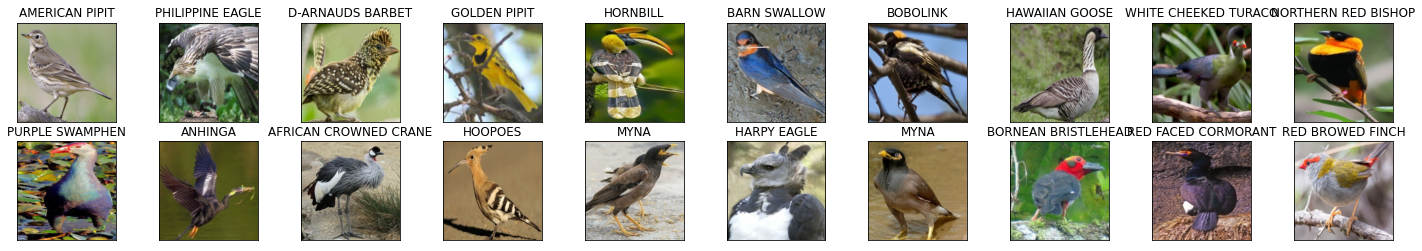

In [18]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(train_dl)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# neural network architecture
class Model(nn.Module):
    def __init__(self):
        
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(64)  
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.batch_norm3 = nn.BatchNorm2d(256)  
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.drop_out1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=4*4*256, out_features=2048)
        self.drop_out2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=2048, out_features=2048)
        self.drop_out3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(in_features=2048, out_features=275)
    def forward(self, x): 
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool1(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool1(F.relu(self.batch_norm3(self.conv3(x))))
        x = x.flatten(1)
        x = self.drop_out1(x)
        x = F.relu(self.fc1(x))
        x = self.drop_out2(x)
        x = F.relu(self.fc2(x))
        x = self.drop_out3(x)
        x = F.relu(self.fc3(x))
        return x
device = torch.device("cuda")
print(device)
 
net = Model()
net.to(device)

cuda


Model(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_out1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (drop_out2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (drop_out3): Dropout(p=0.5, inplace=F

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
for epoch in range(5):
 
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, lables = data
        inputs = inputs.to(device)
        lables = lables.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d,%5d] loss: %.5f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


In [ ]:

correct_predictions = 0
total_predictions = 0
for inputs, labels in valid_dl:
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda() 
        outputs = net(inputs)
        prediction = outputs.argmax(1)
        correct_predictions += prediction.eq(labels.data).sum().item()
        total_predictions += labels.size(0)
print('Validation_Accuracy: %.2f %%' % (100 * (correct_predictions/total_predictions)))

In [ ]:

correct_predictions = 0
total_predictions = 0
for inputs, labels in test_dl:
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda() 
        outputs = net(inputs)
        prediction = outputs.argmax(1)
        correct_predictions += prediction.eq(labels.data).sum().item()
        total_predictions += labels.size(0)
print('Test_Accuracy: %.2f %%' % (100 * (correct_predictions/total_predictions)))